# Imports

In [1]:
import pandas as pd
pd.set_option('display.max_columns', None)
import warnings
warnings.filterwarnings("ignore")

import os, sys
sys.path.append('..')

# Input

In [2]:
target = 'Cases'
result_folder = '../results/TFT_baseline'
figPath = os.path.join(result_folder, 'figures')
results = pd.read_csv(os.path.join(figPath, 'predictions.csv'))
results.head()

,FIPS,TimeFromStart,Predicted_Cases,Cases,Date,split
0,10001,13,7.0,0.0,2020-03-13,train
1,10003,13,17.0,0.0,2020-03-13,train
2,10005,13,9.0,0.0,2020-03-13,train
3,1001,13,3.0,0.0,2020-03-13,train
4,1003,13,10.0,0.0,2020-03-13,train


In [3]:
test = results[results['split']=='test']
test['Date'] = pd.to_datetime(test['Date'])

df = test.groupby(['Date'])[
    [f'Predicted_{target}', target]
].aggregate('sum').reset_index()

df['model'] = 'TFT'
predictions = [df]

In [4]:
for model_dir in ['LSTM', 'BiLSTM', 'NBEATS', 'NHiTS']:
    df = pd.read_csv(f'../../Related Works/results/results_{model_dir}/predictions.csv')
    df = df[df['Split']=='test']
    
    df.drop(['Split'], axis=1, inplace=True)
    df = df.groupby(['Date'])[
        [f'Predicted_{target}', target]
    ].aggregate('sum').reset_index()

    df['model'] = model_dir
    df['Date'] = pd.to_datetime(df['Date'])
    predictions.append(df)

In [5]:
df = pd.concat(predictions, axis=0).reset_index(drop=True)

# Plot

In [6]:
from Class.PlotConfig import *

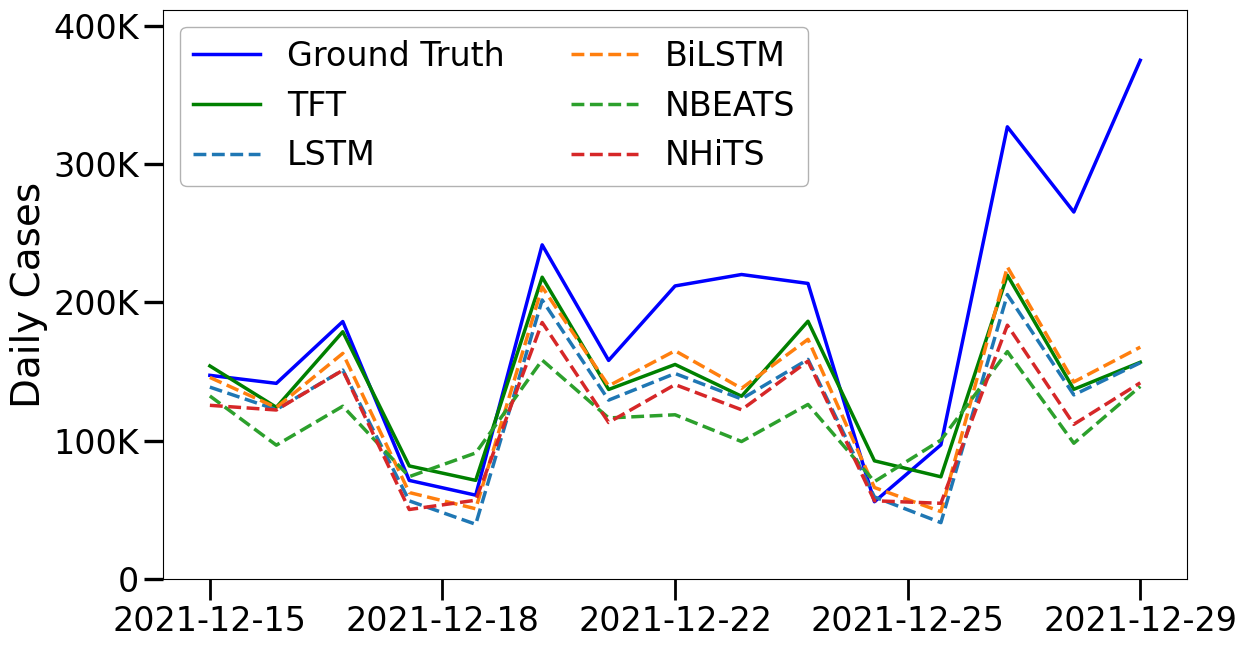

In [8]:
fig, ax = plt.subplots(figsize=(13, 7))
x_column = 'Date'
target = "Cases"
models = ['LSTM', 'BiLSTM', 'NBEATS', 'NHiTS']

prop_cycle = iter(plt.rcParams["axes.prop_cycle"])
X = df[df['model']=='TFT'][x_column]
# plot ground truth
ax.plot(
    X, df[df['model']=='TFT'][target], 
    color='blue', label='Ground Truth' # , linewidth=3
)
ax.plot(
    X, df[df['model']=='TFT'][f'Predicted_{target}'], 
    color='green', label='TFT' # , linewidth=3
)

for index, name in enumerate(models):
    data = df[df['model']==name]

    ax.plot(
        data[x_column], data[f'Predicted_{target}'], 
        color=next(prop_cycle)["color"], label=name, linestyle='--',
        # marker=markers[index], markersize=10, linewidth=linewidth
    )

_, y_max = ax.get_ylim()
ax.set_ylim(0, y_max*1.05)

x_first_tick = df[x_column].min()
x_last_tick = df[x_column].max()
x_major_ticks = 5
ax.set_xticks(
    [x_first_tick + (x_last_tick - x_first_tick) * i / (x_major_ticks - 1) 
     for i in range(x_major_ticks)]
)

label_text = [] 
for loc in ax.get_yticks():
    if loc == 0:
        label_text.append('0')
    else:
        label_text.append(f'{loc/1e3:0.5g}K') 

ax.set_yticklabels(label_text)

ax.legend(loc='upper left', framealpha=0.3, edgecolor="black", ncol=2)

ax.set_ylabel('Daily Cases')

# tight layout is changing y axis values
fig.tight_layout() # might change y axis values
plt.savefig(os.path.join(figPath, 'Test_comparison.jpg'), bbox_inches="tight")
plt.show()